In [1]:
from imp import reload
import os, time
import numpy as np
import pickle
from helpers import comp_evs
import matplotlib.pyplot as plt

# RNN model and task
import torch
use_cuda = torch.cuda.is_available()
from model import RNN, train, run_net
from task_generators import input_driven_fp
task_generator = input_driven_fp

# Data directory for saving
from data_dir import data_dir



# Name
file_name_prefix = "linear" 
torch.cuda.set_device("cuda:3")

In [2]:
# Optimizer
optimizer = 'sgd'

# Nonlinearity
nonlinearity = 'id'
##nonlinearity = 'tanh'

# Integration time step
dt = 0.5
# Training parameters
batch_size = 1
batch_size_test = 1
# Neural noise
noise_std = 0.0
# Whether IO vectors are orthogonalized
orthogonalize_wio = False
# Same random connectivity for each g?
same_connectivity = False

# Number of epochs
n_epochs = 200
# Record the weights only every 'rec_step'
rec_step = 1

# Network parameters
dim_in = 1
dim_out = dim_in

In [3]:
scenario = ['fig_3_4', 'supp_fig_diverge', 'test'][0]

if scenario == 'fig_3_4':
    # Fig 3,4
    dim_rec = 1024

    # Train for different randomness
    dg = 0.1
    gs = np.arange(0, 1, dg)

    # Number of samples
    n_samples = 5

    # Task
    # Target amplitudes
    target_amps = np.array([0.5, 1.0, 2.0])
    # Trail time
    t_max = 101
    # Learning rates for g == 0
    lr0s = np.array([0.015, 0.009, 0.003])

    compute_evs = False

elif scenario == 'supp_fig_diverge':
    # Diverging learning for supplementary
    dim_rec = 256

    # Initial connectivity strength
    gs = np.array([0.6, 0.8])

    # Number of samples
    n_samples = 5

    # Target amplitudes
    # target_amps = np.array([1., 2., 3., 4.])
    target_amps = np.array([2., 4.])
    # Trail time
    t_max = 201
    # Learning rates for g == 0
    # lr0s = np.array([0.009, 0.003, 0.002, 0.001])
    lr0s = np.array([0.002, 0.001])

    compute_evs = True
    file_name_prefix += "_diverge"

elif scenario == 'test':
    # Quick testing
    n_samples = 1
    dim_rec = 256
    n_epochs = 20
    t_max = 21
    gs = np.array([0.0, 0.6])
    target_amps = np.array([0.5, 2.])
    lr0s = np.array([0.01, 0.005])
    file_name_prefix = "test_" + file_name_prefix
    compute_evs = False

In [4]:
# Network dimensions
dims = [dim_in, dim_rec, dim_out]

# All task parameters
task_params_all = [{"t_max": t_max, 
                    "fixation_duration": 1,
                    "decision_duration": 1,
                    "input_amp": 1,
                    "target_amp": target_amp,}
                   for target_amp in target_amps]

# Learning rates
lrs_all = lr0s[:, None] * (1 - gs[None, :]**2)**2

# Epochs
n_rec_epochs = n_epochs // rec_step
epochs = np.arange(n_epochs)
rec_epochs = np.arange(0, n_epochs, rec_step)
# Learning times
tls_all = lrs_all[:, :, None] * epochs[None, None, :]

# Results arrays
n_gs = len(gs)
n_tas = len(target_amps)
# Weights
wi_init_all = np.zeros((n_samples, n_tas, n_gs, dim_in, dim_rec))
wo_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_out))
wrec_init_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
dwrec_last_all = np.zeros((n_samples, n_tas, n_gs, dim_rec, dim_rec))
# Results
losses_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
grad_norms_all = np.zeros((n_samples, n_tas, n_gs, n_epochs))
ev_w_all = np.zeros((n_samples, n_tas, n_gs, n_epochs, dim_rec), dtype=complex)
sv_dw_all = np.zeros((n_samples, n_tas, n_gs, n_rec_epochs, dim_rec))
loss_shuff_all = np.zeros((n_samples, n_tas, n_gs))

# File name
file_name = file_name_prefix
if n_tas == 1:
    target_amp = target_amps[0]
    file_name += "_zhat_%.1f"%target_amp
else:
    file_name += "_zhats"
if n_gs == 1:
    g = gs[0]
    file_name += "_g_%.1f" % g
else:
    file_name += "_gs"
if optimizer != 'sgd':
    file_name += '_' + optimizer
if same_connectivity:
    file_name += "_same_conn"
if orthogonalize_wio:
    file_name += "_ortho_wio"
if noise_std != 0:
    file_name += "_noise_%.1f"%noise_std
# Network parameters
file_name += "_N_%d" % dim_rec
file_name += "_tmax_%d" % t_max
file_name = "".join(file_name.split('.'))
print("file_name:\n", file_name)

# Data file for saving
file_name  = file_name + "_fwdmodeV1"
data_file_name = file_name + ".pkl"
data_file = os.path.join(data_dir, data_file_name)
print("data_file:\n", data_file)


file_name:
 linear_zhats_gs_N_1024_tmax_101
data_file:
 ../data/linear_zhats_gs_N_1024_tmax_101_fwdmodeV1.pkl


In [5]:
def run(mage= True, fwd_mode = True, n_directions_list = 1, lr_factors = 1, task = 0):
    time_t = 0
    time_ev = 0
    time_sv = 0
    time_ls = 0
    all_results = {}
    j = task
    task_params = task_params_all[j]
    task = task_generator(dims, dt, **task_params)
    i = n_gs//2
    g = gs[i]
    
    
    if not isinstance(lr_factors, list):
        lr_factors = [lr_factors]
        
    
    if not isinstance(n_directions_list, list):
        n_directions_list = [n_directions_list]
        
    for n_directions in n_directions_list:
        for lr_factor in lr_factors:
            try:
                lr = lrs_all[j, i]*lr_factor
                if (not same_connectivity) or (i == 0 and j == 0):
                    # Initial connectivity
                    # Random component
                    wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
                    # Input and readout
                    wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
                    if orthogonalize_wio:
                        wio = np.linalg.qr(wio)[0]
                    else:
                        wio /= np.linalg.norm(wio, axis=0)[None, :]
                    # Make sure that the vecotrs are still normalized
                    assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
                    # Change normalization to the proper one
                    wio *= np.sqrt(dim_rec)
                    wi_init = wio[:, :dim_in].T.copy()
                    wo_init = wio[:, dim_in:].copy() / dim_rec
                    del wio

                wrec_init = g * wrec_0

                # Network
                net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init)

                # Train
                time0_t = time.time()
                res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False, fwd_mode = fwd_mode, mage = mage, n_directions = n_directions)
                losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
                # Weights
                all_results[j] = res
                plt.semilogy(losses, label = f"lr = {lr_factor}, directions = {n_directions}")

                if mage:
                    print(f"fwd mage, n_directions= {n_directions}, lr = {lr}")
                elif fwd_mode:
                    print(f"fwd mode, n_directions= {n_directions}, lr = {lr}")
                else:
                    print(f"backprop, lr = {lr}")
            except:
                pass
    plt.legend()
    plt.show()


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0084375


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.016875


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0253125


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.0421875


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.059062500000000004


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 3, lr = 0.0084375


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 3, lr = 0.016875


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 3, lr = 0.0253125


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 3, lr = 0.0421875


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 3, lr = 0.059062500000000004


loss: 7.51e-14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:07<00:00,  2.97it/s]


fwd mage, n_directions= 3, lr = 0.084375


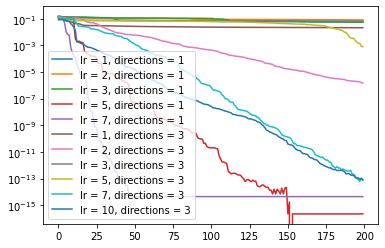

CPU times: user 9min 31s, sys: 35.5 s, total: 10min 7s
Wall time: 9min 7s


In [8]:
%time run(mage = True, fwd_mode = True, n_directions_list = [1,3], lr_factors = [1,2,3,5,7,10])

loss: 1.44e-01:   0%|                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mage, n_directions= 1, lr = 0.00421875


loss: 1.39e-01:   0%|▊                                                                                                                                                         | 1/200 [00:00<00:20,  9.61it/s]

fwd mage, n_directions= 1, lr = 0.0084375


loss: 6.75e-13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.64it/s]


fwd mage, n_directions= 1, lr = 0.016875


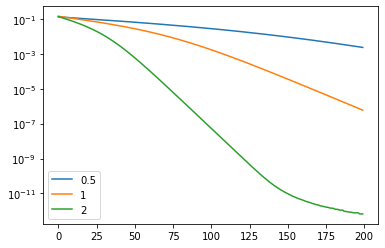

CPU times: user 1min 1s, sys: 3.39 s, total: 1min 4s
Wall time: 53.4 s


In [22]:
%time run(fwd_mode = False, lr_factors = [0.5,1,2])

  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mode, n_directions= 1, lr = 8.4375e-05


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mode, n_directions= 10, lr = 0.0008437500000000001


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mode, n_directions= 10, lr = 8.4375e-05


  0%|                                                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

fwd mode, n_directions= 100, lr = 0.0008437500000000001


loss: 4.44e-16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [28:25<00:00,  8.53s/it]


fwd mode, n_directions= 100, lr = 8.4375e-05


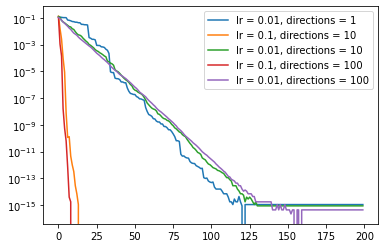

CPU times: user 1h 2min 10s, sys: 4min 5s, total: 1h 6min 15s
Wall time: 1h 3min 49s


In [6]:
%time run(mage = False, fwd_mode = True, n_directions_list = [1,10,100], lr_factors = [1,1/10,1/100])

In [6]:
%%time

print("mage)

time_t = 0
time_ev = 0
time_sv = 0
time_ls = 0
all_results = {}
for k in range(1):    
    for j in range(n_tas):
        task_params = task_params_all[j]
        
        task = task_generator(dims, dt, **task_params)
        
        i = n_gs//2
        g = gs[i]
        lr = lrs_all[j, i]*2
        
        if (not same_connectivity) or (i == 0 and j == 0):
            # Initial connectivity
            # Random component
            wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
            # Input and readout
            wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
            if orthogonalize_wio:
                wio = np.linalg.qr(wio)[0]
            else:
                wio /= np.linalg.norm(wio, axis=0)[None, :]
            # Make sure that the vecotrs are still normalized
            assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
            # Change normalization to the proper one
            wio *= np.sqrt(dim_rec)
            wi_init = wio[:, :dim_in].T.copy()
            wo_init = wio[:, dim_in:].copy() / dim_rec
            del wio

        wrec_init = g * wrec_0

        # Network
        net = RNN(dims, noise_std, dt, nonlinearity, g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init)
        
        # Train
        time0_t = time.time()
        res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False, fwd_mode = True, mage = True, n_directions = 1)
        losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
        # Weights
        all_results[j] = res
        plt.semilogy(losses)
        plt.show()
        
print("Done. Learning took %.1f sec, EV/SV evaluation took %.1f / %.1f sec" % (time_t, time_ev, time_sv))
print("Computing loss after shuffle took %.1f sec" % (time_ls))

# Readout
target_amp = task_params["target_amp"]
zs_all = target_amps[None, :, None, None] - np.sqrt(2 * losses_all)


loss: 0.00e+00:   8%|████████████▏                                                                                                                                            | 16/200 [00:15<02:57,  1.04it/s]


KeyboardInterrupt: 

In [7]:
losses, grad_norms, weights_init, weights_last, weights_train, _, _ = all_results[2]
losses

KeyError: 2